# Model Interpretability

- PDP (Partial Dependency Plot)
- ICE (Individual Conditional Expectation) Plot
- SHAP (Shapley Additive Explanations)
- LIME (Local Interpretable Model-agnostic Explanations)

**Reference**
1. [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/index.html)

## 1. PDP (Partial Dependency Plot)

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

**Disadvantages**
1. **Heterogeneous effects might be hidden** because PDP only show the average marginal effects. THe distribution of predicted value could be either condensed or spread out even the average value is the same.
2. **Inclusion of unrealistic data instances** when features are correlated: Each feature is foreced to be certain value when calculating the PDP. However, when features are dependent, then we might be forcing feature values that do not make sense for this instance.

In [5]:
from sklearn.datasets import make_hastie_10_2
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay

In [6]:
# X, y = make_hastie_10_2(random_state=1995)
# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X, y)

X, y = make_friedman1()
clf = GradientBoostingRegressor(n_estimators=10).fit(X, y)

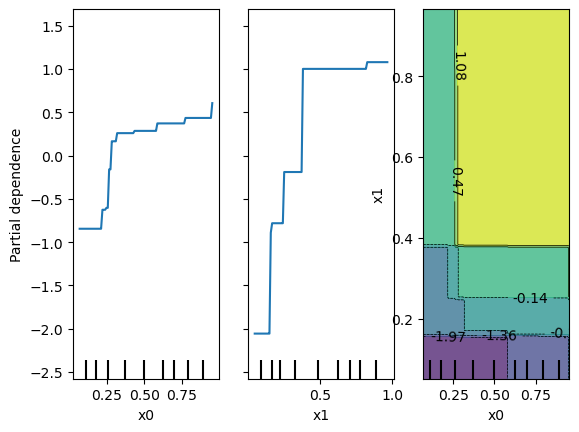

In [7]:
features = [0, 1, (0, 1)]
PartialDependenceDisplay.from_estimator(clf, X, features)

## 2. ICE (Individual Conditional Expectation) Plot

Similar to a PDP, an individual conditional expectation (ICE) plot shows the dependence between the target function and an input feature of interest. However, unlike a PDP, which shows the average effect of the input feature, an ICE plot visualizes the dependence of the prediction on a feature for each sample separately with one line per sample.



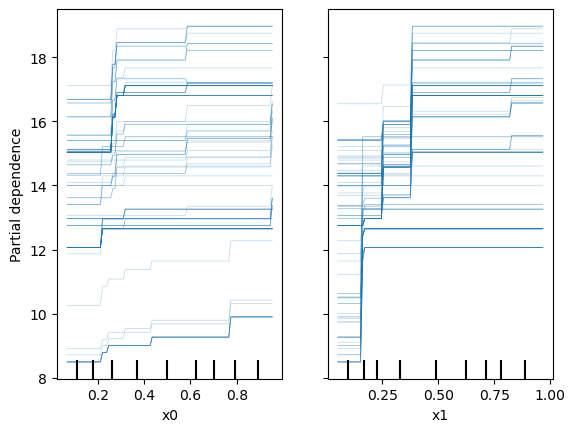

In [8]:
features = [0, 1]
PartialDependenceDisplay.from_estimator(clf, X, features, kind='individual')

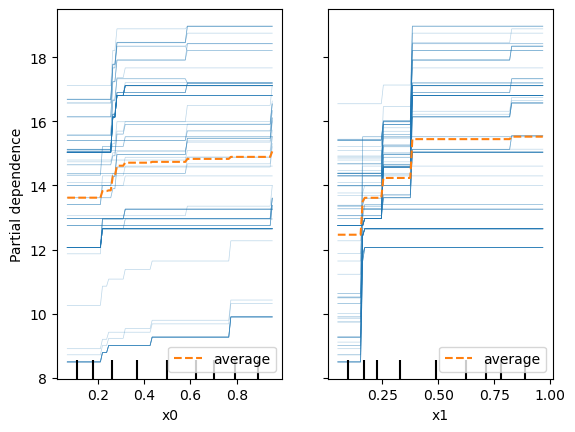

In [9]:
# This shows both ICE plot and PDP together
PartialDependenceDisplay.from_estimator(clf, X, features, kind='both')

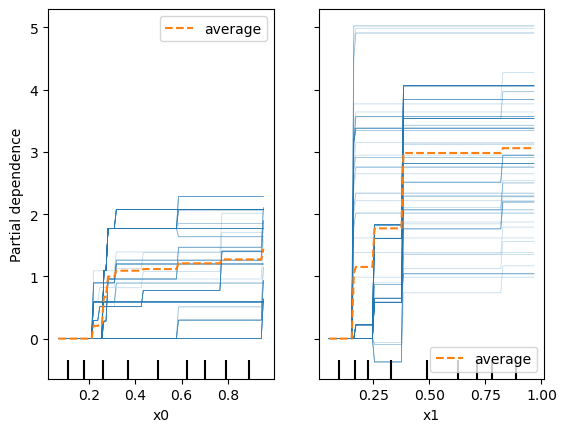

In [10]:
# cICE (centered Individual Conditional Expectation) plot puts emphasis on the divergence of individual conditional expectations from the mean line, 
# thus making it easier to explore heterogeneous relationships.
PartialDependenceDisplay.from_estimator(clf, X, features, kind='both', centered=True)

## 3. [SHAP (Shapley Additive Explanations)](https://github.com/slundberg/shap)

**SHAP values (SHapley Additive exPlanations)** was introduced in coalitional game theory and used as a model agonistic method to increase transparency and interpretability of machine learning models. The Shapley value is calculated as the average marginal contribution of a feature value across all possible coalitions

Total number of possible combinations for the subsets of a model with $n$ features = $n \choose 0$ + $n \choose 1$ + ... + $n \choose n$ = $2^n$

**Interpretation**: The value of the $j$-th feature contributed $\phi_j$ to the prediction of this particular instance compared to the average prediction for the dataset.

Approximations of SHAP values:
1. **Kernel SHAP**:
2. **Tree SHAP**:
- Computational Complexity: **O(#Trees $\times$ Max(#Leaves) $\times$ Max(Depth$)^2$)**
3. **Deep SHAP**:

**Advantages**:
1.  

**Disadvantages**
1. **High computing time** due to $2^n$ possible coalitions for a model with $n$ features
2. **Inclusion of unrealistic data instances** when features are correlated: To simulate that a feature value is missing from a coalition, we marginalize the feature. This is achieved by sampling values from the feature’s marginal distribution. This is fine as long as the features are independent. When features are dependent, then we might sample feature values that do not make sense for this instance.

**Reference**:
1. [Explainable AI explained](https://www.youtube.com/watch?v=9haIOplEIGM)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import shap
import transformers
import xgboost


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


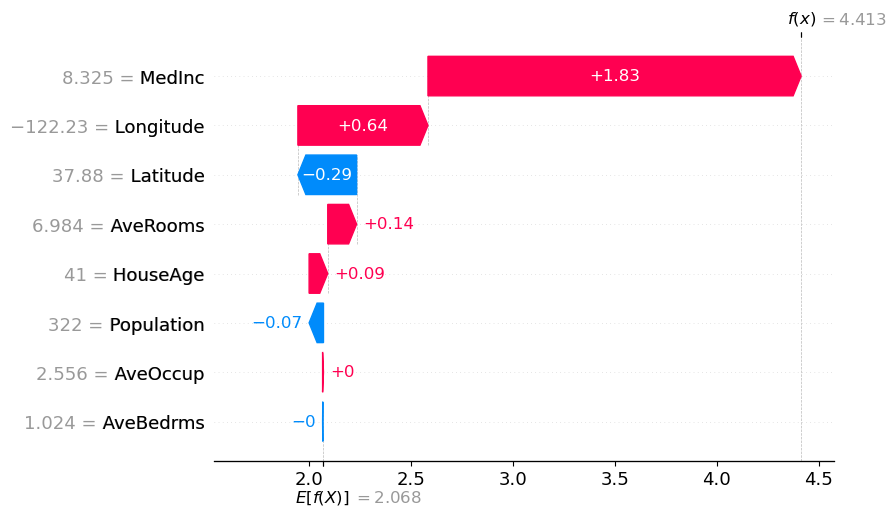

In [2]:
# train an XGBoost model
X, y = shap.datasets.california()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [4]:
# load a transformers pipeline model
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

# explain the model on two sample inputs
explainer = shap.Explainer(model)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
`return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


In [5]:
shap_values = explainer(["What a great movie! ...if you have no taste."])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, "POSITIVE"])

  0%|          | 0/240 [00:00<?, ?it/s]

Partition explainer: 2it [05:20, 320.93s/it]                                                                           


## 4. [LIME (Local Interpretable Model-agnostic Explanations)](https://github.com/marcotcr/lime)

LIME tries to fit a simple interpretable model, locally with respect to the data point of interest, to approximate the complex model prediction we want to explain. A short summary of how LIME works can be like:

1. Select the instance of interest for which we want to have an explanation of its complex model prediction
2. Perturb the training dataset (i.e. generating simulated data points) and get the complex model prediction for these newly generated data points
3. Weight the new data points according to their proximity to the instance of interest
4. Train a weighted, interpretable model on the dataset with the perturbed instances
5. Explain the prediction from complex model by interpreting the local surrogate model

**Mathmatical Formula**

<center>
$\xi (x) = \underset{g \in G}{\operatorname{argmin}} L(f,g,\pi_x) + \Omega(g)$, where 
</center>

- $G = $ Family of interpretable models (e.g. linear regression, |decision tree)
- $g = $ Simple interpretable model
- $f = $ Complex model
- $\pi_x = $ Proximity measure (i.e. local neighborhood) of the input data point
- $\Omega(g) = $ Regularize the complexity of simple surrogate model (e.g. more zero-weighted input features for linear regression, small depth for decision tree)

$z$ is generated around the input data point by perturbation, increase/decrease the values in random features (e.g. sampling from a normal distribution for each feature)

Once the proximity dataset is created, we can minimize the loss function to make sure our local surrogate model $g(x)$ can approximate the prediction result from the complex model $f(x)$

<center>
$L(f,g,\pi_x) =\underset{z,z' \in Z}{\sum} \pi_x(z)(f(z) - g(z'))^2$
</center>

Simulated data points $z$ are weighted in the loss function $L$ by $\pi_x$, the points that are close to the input data point are weighted the most, to ensure the model is locally faithful

**Limitations**
1. **Unclear definition of neighborhood**: It can be hard to determine the right neighborhood to fit the surrogate model and perform the explanation
2. **Non-linearity**: If sparse linear regression was chosen as $g(x)$ and the true relationship in the neighborhood is non-linear, the explanation can be incorrect
3. **Inclusion of unrealistic data instances/Improbable instances**
4. **Instability**: LIME can sometimes produce different explanation results if running multiple times for one instance of interests or for two closely distanced instances of interest

**Reference**:
1. [Explainable AI explained](https://www.youtube.com/watch?v=d6j6bofhj2M&list=PLV8yxwGOxvvovp-j6ztxhF3QcKXT6vORU&index=3)

In [1]:
import lime